# Classifying MNIST with a simple model and quantum embeddings

Inspired by:  https://www.kaggle.com/code/geekysaint/solving-mnist-using-pytorch

Useful imports

In [9]:
# for the Boson Sampler
import perceval as pcvl
#import perceval.providers.scaleway as scw  # Uncomment to allow running on scaleway

# for the machine learning model
import torch
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import time
from boson_sampler import BosonSampler
from utils import MNIST_partial, accuracy, plot_training_metrics, MNIST_partial2
from model import *
from pqnn_model import QuantumLayer, OutputMappingStrategy
import math

## Definition of the Boson Sampler

In [10]:
session = None
# to run a remote session on Scaleway, uncomment the following and fill project_id and token
# session = scw.Session(
#                    platform="sim:sampling:p100",  # or sim:sampling:h100
#                    project_id=""  # Your project id,
#                    token=""  # Your personal API key
#                    )

# start session
if session is not None:
    session.start()

#to display it
# pcvl.pdisplay(bs.create_circuit())
# define device to run the model

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE = {device}')

DEVICE = cpu


## Dataset : a subset of MNIST dataset

In [11]:
# dataset from csv file, to use for the challenge
train_dataset = MNIST_partial2(split = 'train')
val_dataset = MNIST_partial2(split='val')

# filtered_indices = [i for i in range(len(train_dataset)) if train_dataset.df['label'].iloc[i] in [2, 5]]
# # Create a subset dataset
# filtered_dataset = Subset(train_dataset, filtered_indices)
# filtered_indices_val = [i for i in range(len(val_dataset)) if train_dataset.df['label'].iloc[i] in [2, 5]]
# # Create a subset dataset
# filtered_dataset_val = Subset(val_dataset, filtered_indices_val)

batch_size = 10
# train_loader = DataLoader(filtered_dataset, batch_size, shuffle = True)
# val_loader = DataLoader(filtered_dataset_val, batch_size, shuffle = False)
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = False)

## Training loop

In [12]:
def train_model(model, optimizer, num_epochs, train_loader, val_loader, device):
    criterion = nn.CrossEntropyLoss()
    history_train_accuracy, history_val_accuracy, history_train_loss, history_val_loss = [],[],[],[]
    for epoch in range(num_epochs):
        # training
        model.train()
        train_loss_epoch = []
        train_acc_epoch = []
        for step, batch in enumerate(tqdm(train_loader)):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            # print(output, labels)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss_epoch.append(loss.item())
            acc = accuracy(output, labels)
            train_acc_epoch.append(acc)
        model.eval()
        val_loss_epoch = []
        val_acc_epoch = []
        for step, batch in enumerate(tqdm(val_loader)):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            val_loss_epoch.append(loss.item())
            acc = accuracy(output, labels)
            val_acc_epoch.append(acc)
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {sum(train_loss_epoch)/len(train_loss_epoch):.4f}, Val Loss: {sum(val_loss_epoch)/len(val_loss_epoch):.4f}, Train Acc: {sum(train_acc_epoch)/len(train_acc_epoch):.4f}, Val Acc: {sum(val_acc_epoch)/len(val_acc_epoch):.4f}")
        history_train_loss.append(sum(train_loss_epoch)/len(train_loss_epoch))
        history_train_accuracy.append(sum(train_acc_epoch)/len(train_acc_epoch))
        history_val_loss.append(sum(val_loss_epoch)/len(val_loss_epoch))
        history_val_accuracy.append(sum(val_acc_epoch)/len(val_acc_epoch))
    plot_training_metrics(history_train_accuracy, history_val_accuracy, history_train_loss, history_val_loss)


    # validation

## Model definition

The goal is to perform transfer learning from task A to MNIST. First, we try with task A being ImageNet. Therefore :
* We take a ResNet18 pretrained on ImageNet
* Classical comparison : we train the input layer and the last FC layer to classify MNIST
* Quantum training : the FC layer is replaced by a QuantumLayer and a linear layer to map the output of the QuantumLayer to the 10 classes

### Initialisation of the model

In [13]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

In [14]:
pretrained_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Classical Transfer Learning

In [15]:
MODES = 12
# change first conv1 to take 1 input channel as input
pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


# change last FC layer to map to the 10 classes of MNIST
pretrained_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=MODES, bias = True), nn.Linear(in_features=MODES, out_features=2, bias = True))
# almost equivalent to LoRA weights decomposition: instead of having 512x10 weights (+ bias), we have (512*MODES)+(MODES*10) = MODES(512+1


100%|██████████| 14/14 [00:00<00:00, 47.41it/s]


Epoch 1/5: Train Loss: 0.2005, Val Loss: 0.0312, Train Acc: 0.9198, Val Acc: 1.0000


100%|██████████| 14/14 [00:00<00:00, 46.83it/s]


Epoch 2/5: Train Loss: 0.0867, Val Loss: 0.0706, Train Acc: 0.9784, Val Acc: 1.0000


100%|██████████| 14/14 [00:00<00:00, 33.65it/s]


Epoch 3/5: Train Loss: 0.0462, Val Loss: 0.0471, Train Acc: 0.9849, Val Acc: 1.0000


100%|██████████| 14/14 [00:00<00:00, 45.40it/s]


Epoch 4/5: Train Loss: 0.0826, Val Loss: 0.0462, Train Acc: 0.9776, Val Acc: 0.9929


100%|██████████| 14/14 [00:00<00:00, 48.60it/s]


Epoch 5/5: Train Loss: 0.0598, Val Loss: 0.0431, Train Acc: 0.9845, Val Acc: 1.0000


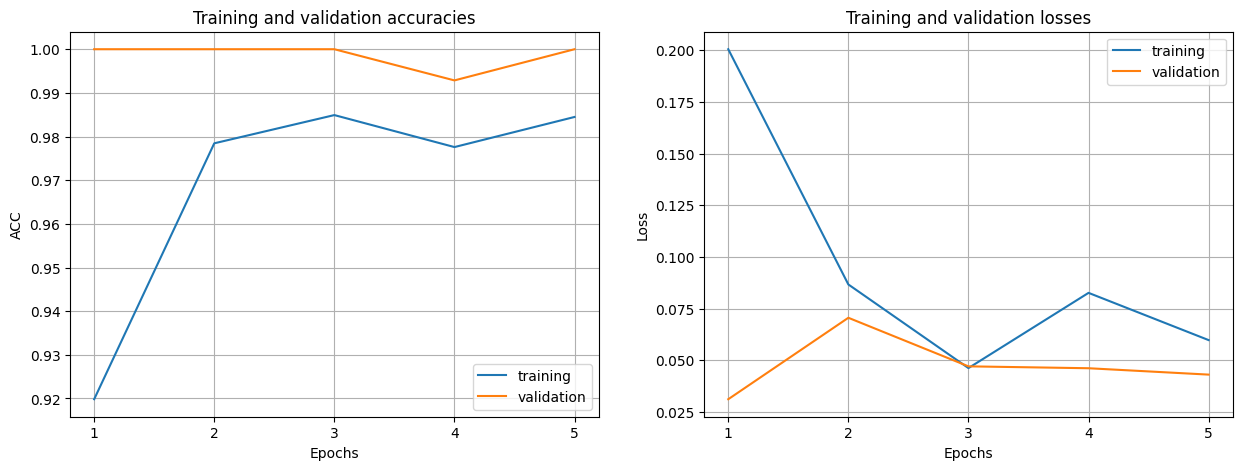

In [16]:
# the model is fully trained
model = pretrained_model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model,optimizer,5,train_loader,val_loader, device)

100%|██████████| 14/14 [00:00<00:00, 44.13it/s]


Epoch 1/5: Train Loss: 0.2512, Val Loss: 0.0463, Train Acc: 0.8961, Val Acc: 0.9857


100%|██████████| 14/14 [00:00<00:00, 48.02it/s]


Epoch 2/5: Train Loss: 0.0788, Val Loss: 0.0450, Train Acc: 0.9672, Val Acc: 1.0000


100%|██████████| 14/14 [00:00<00:00, 47.14it/s]


Epoch 3/5: Train Loss: 0.0368, Val Loss: 0.0155, Train Acc: 0.9879, Val Acc: 1.0000


100%|██████████| 14/14 [00:00<00:00, 44.84it/s]


Epoch 4/5: Train Loss: 0.0125, Val Loss: 0.1571, Train Acc: 0.9957, Val Acc: 0.9405


100%|██████████| 14/14 [00:00<00:00, 44.72it/s]


Epoch 5/5: Train Loss: 0.0195, Val Loss: 0.0271, Train Acc: 0.9974, Val Acc: 0.9929


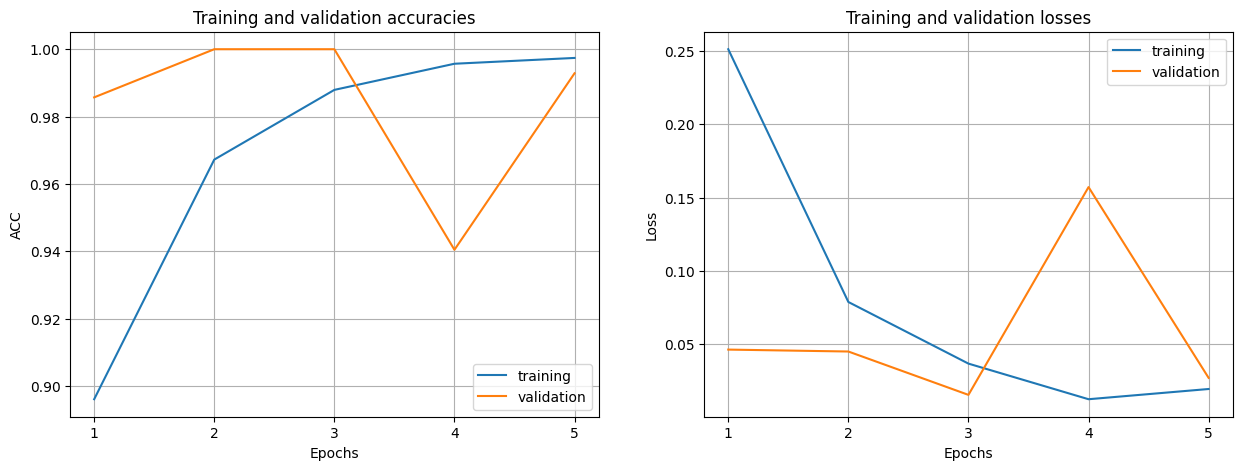

In [17]:
# we only train the first conv and fc layer
MODES = 12

pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# change first conv1 to take 1 input channel as input
pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# change last FC layer to map to the 10 classes of MNIST
pretrained_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=MODES, bias = True), nn.Linear(in_features=MODES, out_features=2, bias = True))

model = pretrained_model.to(device)
model.requires_grad = False
model.conv1.requires_grad = True
model.fc.requires_grad = True

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.001)
train_model(model,optimizer,5,train_loader,val_loader, device)


### Quantum Transfer Learning

In [18]:
MODES = 8
hidden_dim = 128

# change first conv1 to take 1 input channel as input
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

pretrained_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


# first, we consider we have as may modes as features
encoding_circuit = pcvl.Circuit(MODES)
for i in range(0,MODES,2):
    encoding_circuit.add(i , pcvl.BS())
for i in range(1,MODES-1,2):
    encoding_circuit.add(i , pcvl.BS())
for i in range(hidden_dim):
    feat = pcvl.P(f"feat-{i + 1}")
    encoding_circuit.add(i % MODES, pcvl.PS(feat))
pcvl.pdisplay(encoding_circuit)
trainable_circuit = pcvl.GenericInterferometer(MODES, lambda i: (pcvl.BS() #theta=pcvl.P(f"bs_1_{i}")
                                                             .add(0, pcvl.PS(pcvl.P(f"phase_train_1_{i}")))
                                                             .add(0, pcvl.BS()) #theta=pcvl.P(f"bs_1_{i}")
                                                             .add(0, pcvl.PS(pcvl.P(f"phase_train_2_{i}")))
                                                             )
                                          )
circuit = pcvl.Circuit(MODES)
circuit.add(0, encoding_circuit, merge=True)
circuit.add(0, trainable_circuit, merge=True)

input_state = [(i + 1) % 2 for i in range(MODES)]
photon_count = sum(input_state)
qlayer = QuantumLayer(
            input_size=hidden_dim,
            output_size=2, # but we do not use it
            circuit = circuit,
            input_state = input_state,
            trainable_parameters= [p.name for p in circuit.get_parameters() if not p.name.startswith("feat")],
            output_mapping_strategy=OutputMappingStrategy.LINEAR)

# change last FC layer to QLayer + linear layer
pretrained_model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=hidden_dim, bias=True),
                                    qlayer)


100%|██████████| 14/14 [00:03<00:00,  3.82it/s]


Epoch 1/5: Train Loss: 0.6922, Val Loss: 0.6944, Train Acc: 0.5392, Val Acc: 0.5119


100%|██████████| 14/14 [00:03<00:00,  4.17it/s]


Epoch 2/5: Train Loss: 0.6926, Val Loss: 0.6964, Train Acc: 0.5362, Val Acc: 0.5119


100%|██████████| 14/14 [00:03<00:00,  4.20it/s]


Epoch 3/5: Train Loss: 0.6916, Val Loss: 0.6962, Train Acc: 0.5263, Val Acc: 0.5190


100%|██████████| 14/14 [00:04<00:00,  3.47it/s]


Epoch 4/5: Train Loss: 0.6920, Val Loss: 0.6924, Train Acc: 0.5345, Val Acc: 0.5119


100%|██████████| 14/14 [00:03<00:00,  3.66it/s]


Epoch 5/5: Train Loss: 0.6917, Val Loss: 0.6927, Train Acc: 0.5259, Val Acc: 0.5119


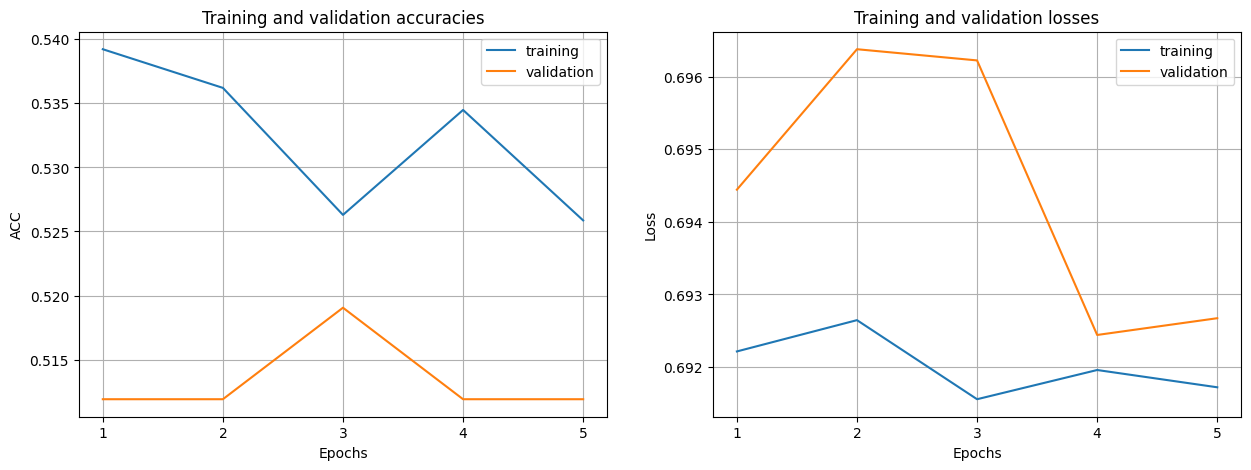

In [19]:
model = pretrained_model.to(device)

#model.requires_grad = False
#model.conv1.requires_grad = True
#model.fc.requires_grad = True

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.01)
train_model(model,optimizer,5,train_loader,val_loader, device)

## Training loop

## Model training

In [20]:
# end session if needed
if session is not None:
    session.stop()